# Load NACD dataset

- categorical variables have already been cell coded
- however, numeric variables have not been standardized

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from models import DNMC, NMC, NSurv, MLP, discrete_ci

import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(2021)

In [2]:
df = pd.read_csv('http://pssp.srv.ualberta.ca/system/predictors/datasets/000/000/032/original/All_Data_updated_may2011_CLEANED.csv?1350302245')

numrc_cols = df.nunique() > 2
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

df

,SURVIVAL,CENSORED,GENDER,BOX1_SCORE,BOX2_SCORE,BOX3_SCORE,PERFORMANCE_STATUS,PERFORMANCE_STATUS_0,PERFORMANCE_STATUS_1,PERFORMANCE_STATUS_2,...,AGE,GRANULOCYTES,LDH_SERUM,LYMPHOCYTES,PLATELET,WBC_COUNT,CALCIUM_SERUM,HGB,CREATININE_SERUM,ALBUMIN
0,-0.988528,0,1,1.463214,3.357897,0.794414,0.830929,0,0,1,...,1.510860,-0.270847,0.628240,-0.862502,-0.147154,-0.504179,-1.462069,-3.192489,-0.129099,-2.537179
1,1.059539,1,0,-0.853622,0.105174,-0.809101,-0.194182,0,1,0,...,1.202266,-0.301723,-0.249949,0.412771,-0.263260,-0.196202,-0.223847,-0.029112,0.440007,-1.132692
2,0.384151,0,0,0.304796,-0.979067,-0.809101,-1.219293,1,0,0,...,1.501878,0.161420,-0.167312,0.707064,1.517029,0.419750,0.723029,0.692360,0.172192,0.037714
3,-0.941069,1,0,-0.853622,0.105174,-0.541848,-0.194182,0,1,0,...,0.646601,-0.548733,-0.262554,1.688043,0.549481,-0.093544,0.358846,-0.084610,0.239146,0.974039
4,-0.267267,0,0,0.304796,0.105174,0.794414,1.856040,0,0,0,...,-0.423449,-0.363476,-0.254151,-0.077719,-1.006337,-0.375855,0.140336,0.525866,-1.099927,0.505877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2397,-0.586857,0,1,1.463214,2.273656,-0.274596,-0.194182,0,1,0,...,0.278762,0.377554,-0.132297,-0.077719,0.371452,0.291427,1.232886,2.468290,0.239146,2.144445
2398,-0.879964,0,1,-0.274413,0.105174,0.794414,0.830929,0,0,1,...,0.244740,-0.054713,-0.118291,-0.077719,0.495298,-0.093544,3.636494,-0.306601,0.339577,-1.834936
2399,0.588593,0,1,1.463214,1.189415,1.328919,0.830929,0,0,1,...,-0.638837,-0.826619,-0.695346,-0.273914,-0.247779,-0.889149,0.504519,-0.750584,-0.129099,1.910364
2400,0.537483,0,1,0.304796,0.105174,0.259909,-0.194182,0,1,0,...,-0.790857,0.130544,-0.202328,0.020379,1.168712,0.137439,0.286010,-0.417597,0.406530,1.442202


In [3]:
df['CENSORED'].value_counts()

0    1523
1     879
Name: CENSORED, dtype: int64

In [4]:
OUTCOMES = ['SURVIVAL', 'CENSORED']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

## We create the semi-synthetic dataset as follows

- real X

- make up new failure times
- make up new failure probabilities
- make up new censoring times

In [5]:
### SET GLOBAL PARAMETERS

N_FEATURES = 10
N_BINS = 10
N_OVERLAPPING = 5
LEARNING_RATE = 6e-4

rs = np.random.RandomState(7)

## Separate Factors

- randomly select separate factors for failure times vs probabilities (no overlap)
- censoring times are random uniform

In [6]:
def discretize(*arrs, nbins=10, pad=1e-5):
    min_val = np.amin(np.stack(arrs))
    max_val = np.amax(np.stack(arrs))
    binsize = (max_val - min_val + pad) / nbins
    return ((arr - arr.min()) // binsize for arr in arrs)
    
def onehot(arr, ncategories=None):
    if ncategories is None:
        ncategories = len(np.unique(arr))
    return np.eye(ncategories)[arr.astype(int)]

In [7]:
feature_order = rs.permutation(len(X.T))
T_features = feature_order[:N_FEATURES]
E_features = feature_order[N_FEATURES:(2 * N_FEATURES)]

T_weights = rs.randn(len(T_features))
E_weights = rs.randn(len(E_features))

T = X[:, T_features] @ T_weights
E = X[:, E_features] @ E_weights

t_cont = np.exp((T - np.mean(T)) / (2 * np.std(T)))
c_cont = rs.rand(len(t_cont)) * t_cont.max()

e_prob = 1 - 1 / (1 + np.exp(4. * (E - E.mean()) / E.std()))
e = (rs.rand(len(e_prob)) < e_prob).astype(int)

ct_cont = np.stack([c_cont, t_cont]).T
y_cont = e * np.amin(ct_cont, axis=1) + (1 - e) * c_cont

s = e * np.argmin(ct_cont, axis=1)
y_disc, t_disc, c_disc = discretize(y_cont, t_cont, c_cont, nbins=N_BINS)

y = onehot(y_disc, ncategories=N_BINS)

How many are susceptible?
0    1335
1    1067
dtype: int64
How many are observed?
0    1581
1     821
dtype: int64


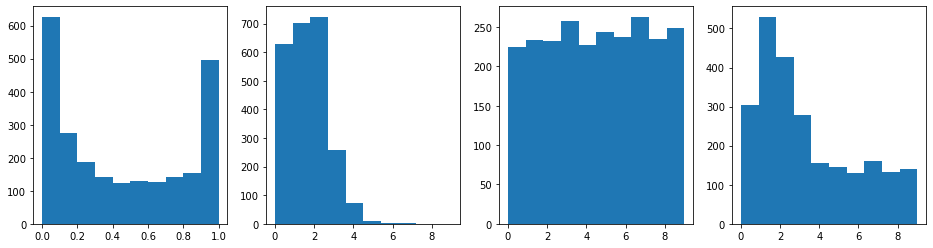

In [8]:
print('How many are susceptible?')
print(pd.value_counts(e).sort_index())

print('How many are observed?')
print(pd.value_counts(s).sort_index())

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

ax[0].hist(e_prob)
ax[1].hist(t_disc)
ax[2].hist(c_disc)
ax[3].hist(y_disc)

plt.show()

In [9]:
x_train, y_train, s_train = X[:1500], y[:1500], s[:1500]
x_val, y_val, s_val = X[1500:1900], y[1500:1900], s[1500:1900]
x_test, y_test, s_test, e_test = X[1900:], y[1900:], s[1900:], e[1900:]
t_disc_test, c_disc_test, y_disc_test = t_disc[1900:], c_disc[1900:], y_disc[1900:]

In [10]:
def get_batches(*arrs, batch_size=1):
    l = len(arrs[0])
    for ndx in range(0, l, batch_size):
        yield (arr[ndx:min(ndx + batch_size, l)] for arr in arrs)
        
import time

def train_model(
    model, train_data, val_data, n_epochs,
    batch_size=50, learning_rate=1e-3, early_stopping_criterion=2):

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    #@tf.function
    def train_step(x, y, s):
        with tf.GradientTape() as tape:
            train_loss, train_nll = model.loss(x, y, s)
            #print(train_loss, train_nll)
        grads = tape.gradient(train_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return train_loss, train_nll

    #@tf.function
    def test_step(x, y, s):
        val_loss, val_nll = model.loss(x, y, s)
        return val_loss, val_nll
    
    best_val_loss = np.inf
    no_decrease = 0

    for epoch_idx in range(n_epochs):

        #print("\nStart of epoch %d" % (epoch_idx,))
        start_time = time.time()

        train_losses = []
        train_nlls = []

        for batch_idx, (xt, yt, st) in enumerate(get_batches(*train_data, batch_size=batch_size)):

            train_loss, train_nll = train_step(xt, yt, st)

            train_losses.append(train_loss)
            train_nlls.append(train_nll)

        # Display metrics at the end of each epoch.
        #print('Epoch training loss: %.4f, NLL = %.4f' % (np.mean(batch_losses), np.mean(batch_nll)))

        val_losses = []
        val_nlls = []

        # Run a validation loop at the end of each epoch.
        for batch_idx, (xv, yv, sv) in enumerate(get_batches(*val_data, batch_size=batch_size)):

            val_loss, val_nll = test_step(xv, yv, sv)

            val_losses.append(val_loss)
            val_nlls.append(val_nll)
            
        new_val_loss = np.mean(val_losses)

        print(
            'Epoch %2i | Train Loss: %.4f | Train NLL: %.4f | Val Loss: %.4f | Val NLL: %.4f'
            % (epoch_idx, np.mean(train_losses), np.mean(train_nlls), np.mean(val_losses), np.mean(val_nlls))
        )
        #print('Time taken: %.2fs' % (time.time() - start_time))
                
        if new_val_loss > best_val_loss:
            no_decrease += 1
        else:
            no_decrease = 0
            best_val_loss = new_val_loss
            
        if no_decrease == early_stopping_criterion:
            break

In [11]:
from sklearn.metrics import roc_auc_score


def nll(t_true, t_pred, tol=1e-8):
    ncat = np.shape(t_pred)[1]
    nll_ = -1 * np.log(np.sum(onehot(t_true, ncategories=ncat) * t_pred, axis=1) + tol)
    return np.mean(nll_)


def evaluate_model(
    model, test_data, e_test, 
    batch_size=50, dataset='nacd', factors='unknown'):
    
    modelname = type(model).__name__
    
    test_losses = []
    test_nlls = []
    
    test_e_pred = []
    test_t_pred = []
    test_c_pred = []
    
    for batch_idx, (xt, yt, st) in enumerate(get_batches(*test_data, batch_size=batch_size)):
        
        test_loss, test_nll = model.loss(xt, yt, st)
        
        if modelname == 'NSurv':
            t_pred, c_pred = model(xt)
            test_t_pred.append(t_pred)
            test_c_pred.append(c_pred)
        elif modelname == 'MLP':
            e_pred = model(xt)
            test_e_pred.append(e_pred)
        else:
            e_pred, t_pred, c_pred = model(xt)
            test_e_pred.append(e_pred)
            test_t_pred.append(t_pred)
            test_c_pred.append(c_pred)
        
        test_losses.append(test_loss)
        test_nlls.append(test_nll)
    
    if modelname == 'NSurv':
        e_auc = None
    else:
        e_auc = roc_auc_score(e_test, np.concatenate(test_e_pred, axis=0))
        
    if modelname == 'MLP':
        ci = None
    else:
        ci = discrete_ci(test_data[2], test_data[1], np.concatenate(test_t_pred, axis=0))
    
    results = {
        'dataset': dataset,
        'factors': factors,
        'model': modelname,
        'ld': model.ld,
        'lr': model.lr,
        'avg_test_loss': np.mean(test_losses),
        'avg_test_nll': np.mean(test_nlls),
        'e_auc': e_auc,
        'y_ci': ci
    }
    
    return results

In [12]:
### BEGIN COLLECTING RESULTS HERE ###
all_results = []

pstrue = s_train.mean()
importance_weights = [1 / (1 - pstrue), 1 / pstrue]

In [13]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=1e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 16.0778 | Train NLL: 4.8416 | Val Loss: 14.2296 | Val NLL: 4.5909
Epoch  1 | Train Loss: 12.5194 | Train NLL: 4.1218 | Val Loss: 11.5345 | Val NLL: 4.3241
Epoch  2 | Train Loss: 10.1551 | Train NLL: 3.8174 | Val Loss: 9.6705 | Val NLL: 4.1569
Epoch  3 | Train Loss: 8.5076 | Train NLL: 3.5980 | Val Loss: 8.3819 | Val NLL: 4.0463
Epoch  4 | Train Loss: 7.3420 | Train NLL: 3.4318 | Val Loss: 7.4577 | Val NLL: 3.9551
Epoch  5 | Train Loss: 6.5012 | Train NLL: 3.3047 | Val Loss: 6.8059 | Val NLL: 3.9051
Epoch  6 | Train Loss: 5.8798 | Train NLL: 3.2042 | Val Loss: 6.3161 | Val NLL: 3.8604
Epoch  7 | Train Loss: 5.4099 | Train NLL: 3.1229 | Val Loss: 5.9509 | Val NLL: 3.8298
Epoch  8 | Train Loss: 5.0454 | Train NLL: 3.0528 | Val Loss: 5.6754 | Val NLL: 3.8105
Epoch  9 | Train Loss: 4.7582 | Train NLL: 2.9927 | Val Loss: 5.4617 | Val NLL: 3.7958
Epoch 10 | Train Loss: 4.5290 | Train NLL: 2.9408 | Val Loss: 5.2917 | Val NLL: 3.7820
Epoch 11 | Train Loss: 4.3420 | Train 

In [14]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-3, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 15.9496 | Train NLL: 4.8215 | Val Loss: 14.0304 | Val NLL: 4.5562
Epoch  1 | Train Loss: 12.3220 | Train NLL: 4.1001 | Val Loss: 11.3243 | Val NLL: 4.2890
Epoch  2 | Train Loss: 9.9658 | Train NLL: 3.7924 | Val Loss: 9.5050 | Val NLL: 4.1434
Epoch  3 | Train Loss: 8.3435 | Train NLL: 3.5737 | Val Loss: 8.2425 | Val NLL: 4.0339
Epoch  4 | Train Loss: 7.2056 | Train NLL: 3.4117 | Val Loss: 7.3634 | Val NLL: 3.9662
Epoch  5 | Train Loss: 6.3875 | Train NLL: 3.2873 | Val Loss: 6.7238 | Val NLL: 3.9105
Epoch  6 | Train Loss: 5.7852 | Train NLL: 3.1897 | Val Loss: 6.2597 | Val NLL: 3.8768
Epoch  7 | Train Loss: 5.3314 | Train NLL: 3.1115 | Val Loss: 5.9078 | Val NLL: 3.8486
Epoch  8 | Train Loss: 4.9773 | Train NLL: 3.0420 | Val Loss: 5.6442 | Val NLL: 3.8323
Epoch  9 | Train Loss: 4.7013 | Train NLL: 2.9849 | Val Loss: 5.4420 | Val NLL: 3.8215
Epoch 10 | Train Loss: 4.4799 | Train NLL: 2.9339 | Val Loss: 5.2879 | Val NLL: 3.8176
Epoch 11 | Train Loss: 4.3001 | Train N

In [15]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 15.9127 | Train NLL: 4.8193 | Val Loss: 13.9673 | Val NLL: 4.5261
Epoch  1 | Train Loss: 12.2887 | Train NLL: 4.0893 | Val Loss: 11.2979 | Val NLL: 4.2755
Epoch  2 | Train Loss: 9.9539 | Train NLL: 3.7874 | Val Loss: 9.4893 | Val NLL: 4.1293
Epoch  3 | Train Loss: 8.3440 | Train NLL: 3.5725 | Val Loss: 8.2427 | Val NLL: 4.0300
Epoch  4 | Train Loss: 7.2123 | Train NLL: 3.4125 | Val Loss: 7.3677 | Val NLL: 3.9637
Epoch  5 | Train Loss: 6.4009 | Train NLL: 3.2932 | Val Loss: 6.7337 | Val NLL: 3.9123
Epoch  6 | Train Loss: 5.8029 | Train NLL: 3.1984 | Val Loss: 6.2676 | Val NLL: 3.8748
Epoch  7 | Train Loss: 5.3476 | Train NLL: 3.1169 | Val Loss: 5.9237 | Val NLL: 3.8530
Epoch  8 | Train Loss: 4.9968 | Train NLL: 3.0496 | Val Loss: 5.6670 | Val NLL: 3.8426
Epoch  9 | Train Loss: 4.7189 | Train NLL: 2.9896 | Val Loss: 5.4689 | Val NLL: 3.8352
Epoch 10 | Train Loss: 4.4968 | Train NLL: 2.9374 | Val Loss: 5.3128 | Val NLL: 3.8290
Epoch 11 | Train Loss: 4.3156 | Train N

In [16]:
model = NMC(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 13.9900 | Train NLL: 4.9401 | Val Loss: 12.5577 | Val NLL: 4.7019
Epoch  1 | Train Loss: 11.2405 | Train NLL: 4.3232 | Val Loss: 10.4234 | Val NLL: 4.4127
Epoch  2 | Train Loss: 9.3308 | Train NLL: 4.0068 | Val Loss: 8.8857 | Val NLL: 4.2200
Epoch  3 | Train Loss: 7.9433 | Train NLL: 3.7729 | Val Loss: 7.7779 | Val NLL: 4.0825
Epoch  4 | Train Loss: 6.9303 | Train NLL: 3.5936 | Val Loss: 6.9722 | Val NLL: 3.9811
Epoch  5 | Train Loss: 6.1826 | Train NLL: 3.4545 | Val Loss: 6.3796 | Val NLL: 3.9063
Epoch  6 | Train Loss: 5.6226 | Train NLL: 3.3443 | Val Loss: 5.9391 | Val NLL: 3.8506
Epoch  7 | Train Loss: 5.1962 | Train NLL: 3.2537 | Val Loss: 5.6070 | Val NLL: 3.8077
Epoch  8 | Train Loss: 4.8654 | Train NLL: 3.1767 | Val Loss: 5.3538 | Val NLL: 3.7746
Epoch  9 | Train Loss: 4.6046 | Train NLL: 3.1103 | Val Loss: 5.1621 | Val NLL: 3.7526
Epoch 10 | Train Loss: 4.3958 | Train NLL: 3.0523 | Val Loss: 5.0104 | Val NLL: 3.7334
Epoch 11 | Train Loss: 4.2256 | Train N

In [17]:
model = NSurv(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 11.0753 | Train NLL: 4.9429 | Val Loss: 10.1742 | Val NLL: 4.7113
Epoch  1 | Train Loss: 9.2315 | Train NLL: 4.3101 | Val Loss: 8.7934 | Val NLL: 4.4036
Epoch  2 | Train Loss: 7.9809 | Train NLL: 4.0067 | Val Loss: 7.7984 | Val NLL: 4.2289
Epoch  3 | Train Loss: 7.0637 | Train NLL: 3.8076 | Val Loss: 7.0636 | Val NLL: 4.1123
Epoch  4 | Train Loss: 6.3686 | Train NLL: 3.6532 | Val Loss: 6.5112 | Val NLL: 4.0265
Epoch  5 | Train Loss: 5.8340 | Train NLL: 3.5289 | Val Loss: 6.0832 | Val NLL: 3.9542
Epoch  6 | Train Loss: 5.4163 | Train NLL: 3.4253 | Val Loss: 5.7487 | Val NLL: 3.8936
Epoch  7 | Train Loss: 5.0835 | Train NLL: 3.3354 | Val Loss: 5.4922 | Val NLL: 3.8503
Epoch  8 | Train Loss: 4.8187 | Train NLL: 3.2608 | Val Loss: 5.2913 | Val NLL: 3.8171
Epoch  9 | Train Loss: 4.6017 | Train NLL: 3.1940 | Val Loss: 5.1350 | Val NLL: 3.7937
Epoch 10 | Train Loss: 4.4233 | Train NLL: 3.1350 | Val Loss: 5.0114 | Val NLL: 3.7764
Epoch 11 | Train Loss: 4.2722 | Train NLL

In [18]:
model = MLP(importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 4.2602 | Train NLL: 1.2552 | Val Loss: 3.7882 | Val NLL: 1.1885
Epoch  1 | Train Loss: 3.3650 | Train NLL: 1.0860 | Val Loss: 3.0889 | Val NLL: 1.1186
Epoch  2 | Train Loss: 2.7444 | Train NLL: 1.0061 | Val Loss: 2.5899 | Val NLL: 1.0732
Epoch  3 | Train Loss: 2.2956 | Train NLL: 0.9441 | Val Loss: 2.2335 | Val NLL: 1.0402
Epoch  4 | Train Loss: 1.9689 | Train NLL: 0.8940 | Val Loss: 1.9776 | Val NLL: 1.0164
Epoch  5 | Train Loss: 1.7295 | Train NLL: 0.8540 | Val Loss: 1.7929 | Val NLL: 1.0002
Epoch  6 | Train Loss: 1.5519 | Train NLL: 0.8222 | Val Loss: 1.6603 | Val NLL: 0.9920
Epoch  7 | Train Loss: 1.4178 | Train NLL: 0.7964 | Val Loss: 1.5625 | Val NLL: 0.9871
Epoch  8 | Train Loss: 1.3145 | Train NLL: 0.7746 | Val Loss: 1.4917 | Val NLL: 0.9868
Epoch  9 | Train Loss: 1.2329 | Train NLL: 0.7551 | Val Loss: 1.4386 | Val NLL: 0.9879
Epoch 10 | Train Loss: 1.1672 | Train NLL: 0.7373 | Val Loss: 1.4000 | Val NLL: 0.9911
Epoch 11 | Train Loss: 1.1135 | Train NLL: 

## Overlapping Factors

In [19]:
feature_order = rs.permutation(len(X.T))
T_features = feature_order[N_OVERLAPPING:(N_FEATURES + N_OVERLAPPING)]
E_features = feature_order[N_FEATURES:(2 * N_FEATURES)]

T_weights = rs.randn(len(T_features))
E_weights = rs.randn(len(E_features))

T = X[:, T_features] @ T_weights
E = X[:, E_features] @ E_weights

t_cont = np.exp((T - np.mean(T)) / (2 * np.std(T)))
c_cont = rs.rand(len(t_cont)) * t_cont.max()

e_prob = 1 - 1 / (1 + np.exp(4. * (E - E.mean()) / E.std()))
e = (rs.rand(len(e_prob)) < e_prob).astype(int)

ct_cont = np.stack([c_cont, t_cont]).T
y_cont = e * np.amin(ct_cont, axis=1) + (1 - e) * c_cont

s = e * np.argmin(ct_cont, axis=1)
y_disc, t_disc, c_disc = discretize(y_cont, t_cont, c_cont, nbins=N_BINS)

y = onehot(y_disc, ncategories=N_BINS)

In [20]:
pstrue = s_train.mean()
importance_weights = [1 / (1 - pstrue), 1 / pstrue]

How many are susceptible?
0    1130
1    1272
dtype: int64
How many are observed?
0    1468
1     934
dtype: int64


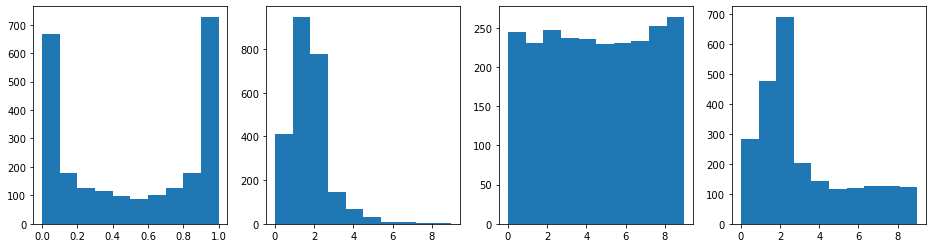

In [21]:
print('How many are susceptible?')
print(pd.value_counts(e).sort_index())

print('How many are observed?')
print(pd.value_counts(s).sort_index())

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

ax[0].hist(e_prob)
ax[1].hist(t_disc)
ax[2].hist(c_disc)
ax[3].hist(y_disc)

plt.show()

In [22]:
x_train, y_train, s_train = X[:1500], y[:1500], s[:1500]
x_val, y_val, s_val = X[1500:1900], y[1500:1900], s[1500:1900]
x_test, y_test, s_test, e_test = X[1900:], y[1900:], s[1900:], e[1900:]
t_disc_test, c_disc_test, y_disc_test = t_disc[1900:], c_disc[1900:], y_disc[1900:]

In [23]:
x_train.shape, y_train.shape, s_train.shape, x_val.shape, y_val.shape, s_val.shape

((1500, 51), (1500, 10), (1500,), (400, 51), (400, 10), (400,))

In [24]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=1e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 15.7654 | Train NLL: 4.5949 | Val Loss: 13.7147 | Val NLL: 4.1408
Epoch  1 | Train Loss: 12.1597 | Train NLL: 3.8107 | Val Loss: 11.0557 | Val NLL: 3.8742
Epoch  2 | Train Loss: 9.8389 | Train NLL: 3.5187 | Val Loss: 9.2427 | Val NLL: 3.7362
Epoch  3 | Train Loss: 8.2391 | Train NLL: 3.3341 | Val Loss: 7.9912 | Val NLL: 3.6573
Epoch  4 | Train Loss: 7.1116 | Train NLL: 3.2058 | Val Loss: 7.1055 | Val NLL: 3.6081
Epoch  5 | Train Loss: 6.2954 | Train NLL: 3.1088 | Val Loss: 6.4532 | Val NLL: 3.5646
Epoch  6 | Train Loss: 5.6891 | Train NLL: 3.0311 | Val Loss: 5.9759 | Val NLL: 3.5396
Epoch  7 | Train Loss: 5.2290 | Train NLL: 2.9669 | Val Loss: 5.6114 | Val NLL: 3.5173
Epoch  8 | Train Loss: 4.8712 | Train NLL: 2.9111 | Val Loss: 5.3312 | Val NLL: 3.5004
Epoch  9 | Train Loss: 4.5886 | Train NLL: 2.8621 | Val Loss: 5.1160 | Val NLL: 3.4901
Epoch 10 | Train Loss: 4.3651 | Train NLL: 2.8213 | Val Loss: 4.9448 | Val NLL: 3.4801
Epoch 11 | Train Loss: 4.1810 | Train N

In [25]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-3, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 15.8835 | Train NLL: 4.6954 | Val Loss: 13.7793 | Val NLL: 4.1892
Epoch  1 | Train Loss: 12.2048 | Train NLL: 3.8565 | Val Loss: 11.0314 | Val NLL: 3.8671
Epoch  2 | Train Loss: 9.8427 | Train NLL: 3.5504 | Val Loss: 9.2146 | Val NLL: 3.7451
Epoch  3 | Train Loss: 8.2289 | Train NLL: 3.3645 | Val Loss: 7.9600 | Val NLL: 3.6686
Epoch  4 | Train Loss: 7.0982 | Train NLL: 3.2337 | Val Loss: 7.0747 | Val NLL: 3.6167
Epoch  5 | Train Loss: 6.2844 | Train NLL: 3.1338 | Val Loss: 6.4327 | Val NLL: 3.5769
Epoch  6 | Train Loss: 5.6794 | Train NLL: 3.0503 | Val Loss: 5.9532 | Val NLL: 3.5425
Epoch  7 | Train Loss: 5.2229 | Train NLL: 2.9829 | Val Loss: 5.5916 | Val NLL: 3.5168
Epoch  8 | Train Loss: 4.8697 | Train NLL: 2.9261 | Val Loss: 5.3184 | Val NLL: 3.5017
Epoch  9 | Train Loss: 4.5917 | Train NLL: 2.8774 | Val Loss: 5.1035 | Val NLL: 3.4884
Epoch 10 | Train Loss: 4.3673 | Train NLL: 2.8330 | Val Loss: 4.9366 | Val NLL: 3.4803
Epoch 11 | Train Loss: 4.1853 | Train N

In [26]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 15.9304 | Train NLL: 4.6981 | Val Loss: 13.8646 | Val NLL: 4.1987
Epoch  1 | Train Loss: 12.3091 | Train NLL: 3.8711 | Val Loss: 11.1613 | Val NLL: 3.8998
Epoch  2 | Train Loss: 9.9467 | Train NLL: 3.5579 | Val Loss: 9.3309 | Val NLL: 3.7693
Epoch  3 | Train Loss: 8.3179 | Train NLL: 3.3693 | Val Loss: 8.0589 | Val NLL: 3.6933
Epoch  4 | Train Loss: 7.1683 | Train NLL: 3.2388 | Val Loss: 7.1576 | Val NLL: 3.6448
Epoch  5 | Train Loss: 6.3373 | Train NLL: 3.1401 | Val Loss: 6.4980 | Val NLL: 3.6041
Epoch  6 | Train Loss: 5.7193 | Train NLL: 3.0583 | Val Loss: 6.0143 | Val NLL: 3.5783
Epoch  7 | Train Loss: 5.2535 | Train NLL: 2.9929 | Val Loss: 5.6442 | Val NLL: 3.5536
Epoch  8 | Train Loss: 4.8933 | Train NLL: 2.9367 | Val Loss: 5.3636 | Val NLL: 3.5374
Epoch  9 | Train Loss: 4.6109 | Train NLL: 2.8888 | Val Loss: 5.1477 | Val NLL: 3.5270
Epoch 10 | Train Loss: 4.3821 | Train NLL: 2.8432 | Val Loss: 4.9792 | Val NLL: 3.5200
Epoch 11 | Train Loss: 4.1977 | Train N

In [27]:
model = NMC(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 13.9120 | Train NLL: 4.8053 | Val Loss: 12.2391 | Val NLL: 4.3127
Epoch  1 | Train Loss: 11.0075 | Train NLL: 4.0149 | Val Loss: 10.0219 | Val NLL: 3.9297
Epoch  2 | Train Loss: 9.0728 | Train NLL: 3.6652 | Val Loss: 8.4937 | Val NLL: 3.7438
Epoch  3 | Train Loss: 7.7098 | Train NLL: 3.4589 | Val Loss: 7.4117 | Val NLL: 3.6402
Epoch  4 | Train Loss: 6.7274 | Train NLL: 3.3211 | Val Loss: 6.6278 | Val NLL: 3.5734
Epoch  5 | Train Loss: 6.0071 | Train NLL: 3.2229 | Val Loss: 6.0499 | Val NLL: 3.5266
Epoch  6 | Train Loss: 5.4664 | Train NLL: 3.1450 | Val Loss: 5.6207 | Val NLL: 3.4948
Epoch  7 | Train Loss: 5.0547 | Train NLL: 3.0814 | Val Loss: 5.2928 | Val NLL: 3.4676
Epoch  8 | Train Loss: 4.7328 | Train NLL: 3.0247 | Val Loss: 5.0442 | Val NLL: 3.4497
Epoch  9 | Train Loss: 4.4803 | Train NLL: 2.9768 | Val Loss: 4.8492 | Val NLL: 3.4339
Epoch 10 | Train Loss: 4.2774 | Train NLL: 2.9332 | Val Loss: 4.7009 | Val NLL: 3.4259
Epoch 11 | Train Loss: 4.1117 | Train N

In [28]:
model = NSurv(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 10.9550 | Train NLL: 4.8098 | Val Loss: 9.8376 | Val NLL: 4.3649
Epoch  1 | Train Loss: 9.0074 | Train NLL: 4.0782 | Val Loss: 8.4099 | Val NLL: 4.0141
Epoch  2 | Train Loss: 7.7286 | Train NLL: 3.7457 | Val Loss: 7.4178 | Val NLL: 3.8363
Epoch  3 | Train Loss: 6.8048 | Train NLL: 3.5346 | Val Loss: 6.6956 | Val NLL: 3.7290
Epoch  4 | Train Loss: 6.1191 | Train NLL: 3.3895 | Val Loss: 6.1569 | Val NLL: 3.6590
Epoch  5 | Train Loss: 5.5993 | Train NLL: 3.2835 | Val Loss: 5.7467 | Val NLL: 3.6093
Epoch  6 | Train Loss: 5.1969 | Train NLL: 3.2004 | Val Loss: 5.4293 | Val NLL: 3.5711
Epoch  7 | Train Loss: 4.8789 | Train NLL: 3.1309 | Val Loss: 5.1794 | Val NLL: 3.5399
Epoch  8 | Train Loss: 4.6234 | Train NLL: 3.0711 | Val Loss: 4.9840 | Val NLL: 3.5176
Epoch  9 | Train Loss: 4.4157 | Train NLL: 3.0187 | Val Loss: 4.8243 | Val NLL: 3.4957
Epoch 10 | Train Loss: 4.2435 | Train NLL: 2.9708 | Val Loss: 4.7018 | Val NLL: 3.4842
Epoch 11 | Train Loss: 4.0998 | Train NLL:

In [29]:
model = MLP(importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 4.2018 | Train NLL: 1.2078 | Val Loss: 3.8075 | Val NLL: 1.2212
Epoch  1 | Train Loss: 3.2771 | Train NLL: 1.0117 | Val Loss: 3.1514 | Val NLL: 1.1960
Epoch  2 | Train Loss: 2.6737 | Train NLL: 0.9522 | Val Loss: 2.6752 | Val NLL: 1.1768
Epoch  3 | Train Loss: 2.2461 | Train NLL: 0.9148 | Val Loss: 2.3374 | Val NLL: 1.1658
Epoch  4 | Train Loss: 1.9386 | Train NLL: 0.8873 | Val Loss: 2.0942 | Val NLL: 1.1580
Epoch  5 | Train Loss: 1.7140 | Train NLL: 0.8652 | Val Loss: 1.9175 | Val NLL: 1.1523
Epoch  6 | Train Loss: 1.5476 | Train NLL: 0.8466 | Val Loss: 1.7869 | Val NLL: 1.1474
Epoch  7 | Train Loss: 1.4214 | Train NLL: 0.8295 | Val Loss: 1.6898 | Val NLL: 1.1438
Epoch  8 | Train Loss: 1.3242 | Train NLL: 0.8142 | Val Loss: 1.6178 | Val NLL: 1.1424
Epoch  9 | Train Loss: 1.2478 | Train NLL: 0.8000 | Val Loss: 1.5631 | Val NLL: 1.1418
Epoch 10 | Train Loss: 1.1857 | Train NLL: 0.7858 | Val Loss: 1.5240 | Val NLL: 1.1445
Epoch 11 | Train Loss: 1.1350 | Train NLL: 

## Dependent Censoring

In [30]:
feature_order = rs.permutation(len(X.T))
T_features = feature_order[N_OVERLAPPING:(N_FEATURES + N_OVERLAPPING)]
E_features = feature_order[N_FEATURES:(2 * N_FEATURES)]
C_features = feature_order[(2 * N_FEATURES - N_OVERLAPPING):(3 * N_FEATURES - N_OVERLAPPING)]

T_weights = rs.randn(len(T_features))
E_weights = rs.randn(len(E_features))
C_weights = rs.randn(len(C_features))

T = X[:, T_features] @ T_weights
E = X[:, E_features] @ E_weights
C = X[:, C_features] @ C_weights

t_cont = np.exp((T - np.mean(T)) / (2 * np.std(T)))
c_cont = np.exp((C - np.mean(C)) / (2 * np.std(C)))

e_prob = 1 - 1 / (1 + np.exp(4. * (E - E.mean()) / E.std()))
e = (rs.rand(len(e_prob)) < e_prob).astype(int)

ct_cont = np.stack([c_cont, t_cont]).T
y_cont = e * np.amin(ct_cont, axis=1) + (1 - e) * c_cont

s = e * np.argmin(ct_cont, axis=1)
y_disc, t_disc, c_disc = discretize(y_cont, t_cont, c_cont, nbins=N_BINS)

y = onehot(y_disc, ncategories=N_BINS)

In [31]:
pstrue = s_train.mean()
importance_weights = [1 / (1 - pstrue), 1 / pstrue]

How many are susceptible?
0    1234
1    1168
dtype: int64
How many are observed?
0    1838
1     564
dtype: int64


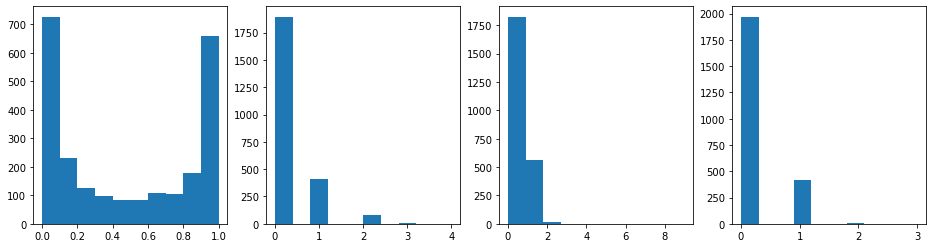

In [32]:
print('How many are susceptible?')
print(pd.value_counts(e).sort_index())

print('How many are observed?')
print(pd.value_counts(s).sort_index())

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

ax[0].hist(e_prob)
ax[1].hist(t_disc)
ax[2].hist(c_disc)
ax[3].hist(y_disc)

plt.show()

In [33]:
x_train, y_train, s_train = X[:1500], y[:1500], s[:1500]
x_val, y_val, s_val = X[1500:1900], y[1500:1900], s[1500:1900]
x_test, y_test, s_test, e_test = X[1900:], y[1900:], s[1900:], e[1900:]
t_disc_test, c_disc_test, y_disc_test = t_disc[1900:], c_disc[1900:], y_disc[1900:]

In [34]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=1e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 12.8297 | Train NLL: 1.7107 | Val Loss: 10.2858 | Val NLL: 1.0183
Epoch  1 | Train Loss: 8.5090 | Train NLL: 0.7315 | Val Loss: 7.1565 | Val NLL: 0.7874
Epoch  2 | Train Loss: 5.8882 | Train NLL: 0.5393 | Val Loss: 5.0763 | Val NLL: 0.6720
Epoch  3 | Train Loss: 4.1825 | Train NLL: 0.4494 | Val Loss: 3.7291 | Val NLL: 0.6139
Epoch  4 | Train Loss: 3.0675 | Train NLL: 0.3929 | Val Loss: 2.8402 | Val NLL: 0.5716
Epoch  5 | Train Loss: 2.3323 | Train NLL: 0.3556 | Val Loss: 2.2528 | Val NLL: 0.5456
Epoch  6 | Train Loss: 1.8377 | Train NLL: 0.3279 | Val Loss: 1.8554 | Val NLL: 0.5287
Epoch  7 | Train Loss: 1.4964 | Train NLL: 0.3065 | Val Loss: 1.5773 | Val NLL: 0.5146
Epoch  8 | Train Loss: 1.2546 | Train NLL: 0.2893 | Val Loss: 1.3790 | Val NLL: 0.5046
Epoch  9 | Train Loss: 1.0790 | Train NLL: 0.2758 | Val Loss: 1.2344 | Val NLL: 0.4974
Epoch 10 | Train Loss: 0.9482 | Train NLL: 0.2643 | Val Loss: 1.1236 | Val NLL: 0.4889
Epoch 11 | Train Loss: 0.8499 | Train NLL

In [35]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-3, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 12.8721 | Train NLL: 1.7193 | Val Loss: 10.3182 | Val NLL: 1.0227
Epoch  1 | Train Loss: 8.5223 | Train NLL: 0.7302 | Val Loss: 7.1538 | Val NLL: 0.7797
Epoch  2 | Train Loss: 5.8919 | Train NLL: 0.5461 | Val Loss: 5.0546 | Val NLL: 0.6596
Epoch  3 | Train Loss: 4.1774 | Train NLL: 0.4581 | Val Loss: 3.7048 | Val NLL: 0.6076
Epoch  4 | Train Loss: 3.0548 | Train NLL: 0.4022 | Val Loss: 2.8168 | Val NLL: 0.5728
Epoch  5 | Train Loss: 2.3117 | Train NLL: 0.3629 | Val Loss: 2.2217 | Val NLL: 0.5447
Epoch  6 | Train Loss: 1.8127 | Train NLL: 0.3346 | Val Loss: 1.8178 | Val NLL: 0.5238
Epoch  7 | Train Loss: 1.4696 | Train NLL: 0.3126 | Val Loss: 1.5400 | Val NLL: 0.5102
Epoch  8 | Train Loss: 1.2275 | Train NLL: 0.2947 | Val Loss: 1.3398 | Val NLL: 0.4973
Epoch  9 | Train Loss: 1.0543 | Train NLL: 0.2817 | Val Loss: 1.1973 | Val NLL: 0.4897
Epoch 10 | Train Loss: 0.9251 | Train NLL: 0.2692 | Val Loss: 1.0908 | Val NLL: 0.4829
Epoch 11 | Train Loss: 0.8270 | Train NLL

In [36]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 12.7553 | Train NLL: 1.6323 | Val Loss: 10.2361 | Val NLL: 1.0037
Epoch  1 | Train Loss: 8.4305 | Train NLL: 0.7150 | Val Loss: 7.0618 | Val NLL: 0.7725
Epoch  2 | Train Loss: 5.7943 | Train NLL: 0.5309 | Val Loss: 4.9642 | Val NLL: 0.6483
Epoch  3 | Train Loss: 4.0876 | Train NLL: 0.4414 | Val Loss: 3.6204 | Val NLL: 0.5896
Epoch  4 | Train Loss: 2.9809 | Train NLL: 0.3858 | Val Loss: 2.7465 | Val NLL: 0.5520
Epoch  5 | Train Loss: 2.2564 | Train NLL: 0.3481 | Val Loss: 2.1716 | Val NLL: 0.5271
Epoch  6 | Train Loss: 1.7729 | Train NLL: 0.3206 | Val Loss: 1.7845 | Val NLL: 0.5100
Epoch  7 | Train Loss: 1.4412 | Train NLL: 0.2991 | Val Loss: 1.5145 | Val NLL: 0.4955
Epoch  8 | Train Loss: 1.2083 | Train NLL: 0.2830 | Val Loss: 1.3245 | Val NLL: 0.4864
Epoch  9 | Train Loss: 1.0395 | Train NLL: 0.2693 | Val Loss: 1.1847 | Val NLL: 0.4778
Epoch 10 | Train Loss: 0.9147 | Train NLL: 0.2582 | Val Loss: 1.0828 | Val NLL: 0.4731
Epoch 11 | Train Loss: 0.8203 | Train NLL

In [37]:
model = NMC(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 10.9948 | Train NLL: 1.9170 | Val Loss: 9.0338 | Val NLL: 1.2208
Epoch  1 | Train Loss: 7.5460 | Train NLL: 0.8306 | Val Loss: 6.5570 | Val NLL: 0.8974
Epoch  2 | Train Loss: 5.4740 | Train NLL: 0.6175 | Val Loss: 4.8172 | Val NLL: 0.7235
Epoch  3 | Train Loss: 4.0279 | Train NLL: 0.5020 | Val Loss: 3.6205 | Val NLL: 0.6315
Epoch  4 | Train Loss: 3.0272 | Train NLL: 0.4356 | Val Loss: 2.8033 | Val NLL: 0.5861
Epoch  5 | Train Loss: 2.3307 | Train NLL: 0.3909 | Val Loss: 2.2399 | Val NLL: 0.5603
Epoch  6 | Train Loss: 1.8431 | Train NLL: 0.3578 | Val Loss: 1.8451 | Val NLL: 0.5414
Epoch  7 | Train Loss: 1.4990 | Train NLL: 0.3323 | Val Loss: 1.5669 | Val NLL: 0.5281
Epoch  8 | Train Loss: 1.2523 | Train NLL: 0.3115 | Val Loss: 1.3644 | Val NLL: 0.5151
Epoch  9 | Train Loss: 1.0734 | Train NLL: 0.2953 | Val Loss: 1.2190 | Val NLL: 0.5074
Epoch 10 | Train Loss: 0.9402 | Train NLL: 0.2813 | Val Loss: 1.1107 | Val NLL: 0.5011
Epoch 11 | Train Loss: 0.8395 | Train NLL:

In [38]:
model = NSurv(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 7.9641 | Train NLL: 1.7512 | Val Loss: 6.6249 | Val NLL: 1.1184
Epoch  1 | Train Loss: 5.6065 | Train NLL: 0.7541 | Val Loss: 5.0321 | Val NLL: 0.8261
Epoch  2 | Train Loss: 4.2560 | Train NLL: 0.5620 | Val Loss: 3.8715 | Val NLL: 0.6721
Epoch  3 | Train Loss: 3.2803 | Train NLL: 0.4616 | Val Loss: 3.0497 | Val NLL: 0.5981
Epoch  4 | Train Loss: 2.5738 | Train NLL: 0.4030 | Val Loss: 2.4603 | Val NLL: 0.5596
Epoch  5 | Train Loss: 2.0572 | Train NLL: 0.3633 | Val Loss: 2.0305 | Val NLL: 0.5349
Epoch  6 | Train Loss: 1.6771 | Train NLL: 0.3337 | Val Loss: 1.7138 | Val NLL: 0.5162
Epoch  7 | Train Loss: 1.3945 | Train NLL: 0.3096 | Val Loss: 1.4779 | Val NLL: 0.5011
Epoch  8 | Train Loss: 1.1836 | Train NLL: 0.2909 | Val Loss: 1.3007 | Val NLL: 0.4887
Epoch  9 | Train Loss: 1.0243 | Train NLL: 0.2758 | Val Loss: 1.1672 | Val NLL: 0.4796
Epoch 10 | Train Loss: 0.9023 | Train NLL: 0.2629 | Val Loss: 1.0644 | Val NLL: 0.4714
Epoch 11 | Train Loss: 0.8085 | Train NLL: 

In [39]:
model = MLP(importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 4.0572 | Train NLL: 1.0836 | Val Loss: 3.5114 | Val NLL: 0.9406
Epoch  1 | Train Loss: 3.1001 | Train NLL: 0.8460 | Val Loss: 2.7532 | Val NLL: 0.8030
Epoch  2 | Train Loss: 2.4219 | Train NLL: 0.7027 | Val Loss: 2.2211 | Val NLL: 0.7224
Epoch  3 | Train Loss: 1.9446 | Train NLL: 0.6126 | Val Loss: 1.8563 | Val NLL: 0.6834
Epoch  4 | Train Loss: 1.6068 | Train NLL: 0.5540 | Val Loss: 1.5909 | Val NLL: 0.6527
Epoch  5 | Train Loss: 1.3620 | Train NLL: 0.5107 | Val Loss: 1.4024 | Val NLL: 0.6340
Epoch  6 | Train Loss: 1.1808 | Train NLL: 0.4760 | Val Loss: 1.2654 | Val NLL: 0.6211
Epoch  7 | Train Loss: 1.0444 | Train NLL: 0.4471 | Val Loss: 1.1646 | Val NLL: 0.6123
Epoch  8 | Train Loss: 0.9392 | Train NLL: 0.4221 | Val Loss: 1.0890 | Val NLL: 0.6055
Epoch  9 | Train Loss: 0.8573 | Train NLL: 0.4007 | Val Loss: 1.0334 | Val NLL: 0.6024
Epoch 10 | Train Loss: 0.7922 | Train NLL: 0.3819 | Val Loss: 0.9907 | Val NLL: 0.6001
Epoch 11 | Train Loss: 0.7394 | Train NLL: 

# Summary of results

In [40]:
summary = pd.DataFrame(all_results)
summary.to_csv('~/Downloads/nacd_results.csv', index=False)
summary

,dataset,factors,model,ld,lr,avg_test_loss,avg_test_nll,e_auc,y_ci
0,nacd,separate,DNMC,0.010,0.01,NaN,3.904205,0.888634,0.665129
1,nacd,separate,DNMC,0.003,0.01,NaN,3.940007,0.887542,0.668540
2,nacd,separate,DNMC,0.030,0.01,NaN,3.930373,0.889276,0.669591
3,nacd,separate,NMC,0.001,0.01,4.594212,3.790836,0.896005,0.679137
4,nacd,separate,NSurv,0.001,0.01,4.646095,3.814530,NaN,0.870522
5,nacd,separate,MLP,0.001,0.01,1.296782,1.012142,0.863839,NaN
6,nacd,overlapping,DNMC,0.010,0.01,4.412213,3.587344,0.916140,0.653026
7,nacd,overlapping,DNMC,0.003,0.01,4.387992,3.567028,0.920801,0.674846
8,nacd,overlapping,DNMC,0.030,0.01,4.370396,3.546387,0.920913,0.665059
9,nacd,overlapping,NMC,0.001,0.01,4.207434,3.466679,0.920993,0.640195


### Identification of Factors?

In [41]:
# # Trying to work toward evidence of identification of factors
# # Phi -> E, Omega -> T

# E_mask = np.array([False] * X.shape[1])
# E_mask[E_features] = True

# T_mask = np.array([False] * X.shape[1])
# T_mask[T_features] = True

# phi_on_e = np.abs(model.phi_layers[0].kernel.numpy()).max(axis=1)[E_mask].mean()
# phi_off_e = np.abs(model.phi_layers[0].kernel.numpy()).max(axis=1)[~E_mask].mean()

# omega_on_t = np.abs(model.omega_layers[0].kernel.numpy()).max(axis=1)[T_mask].mean()
# omega_off_t = np.abs(model.omega_layers[0].kernel.numpy()).max(axis=1)[~T_mask].mean()

# print(phi_on_e, phi_off_e, omega_on_t, omega_off_t)